## <3-3 셀프 어텐션 동작 원리>  
트랜스포머의 핵심 구성 요소는 셀프 어텐션입니다.  
여기서는 셀프 어텐션의 내부 동작 원리를 살펴봅니다.

### 모델 입력과 출력 
---
셀프 어텐션을 이해하려면 먼저 입력부터 살펴봐야 합니다.  
다음 그림은 트랜스포머 모델의 전체 구조에서 인코더 입력만을 떼어 낸 그림입니다. 이처럼 모델의 입력을 만드는 계층을 ***입력층(input layer)*** 이라고 합니다.

<center><그림 3-23 인코더 입력></center>  

<p align="center">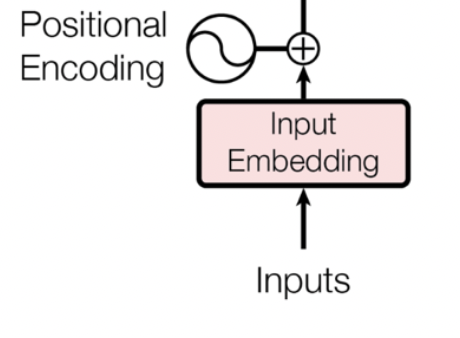

그림에서 확인할 수 있듯이 인코더 입력은 소스 시퀀스의 입력 임베딩에 ***위치 정보(positional encoding)*** 를 더해서 만듭니다.  
한국어에서 영어로 기계 번역을 수행하는 트랜스포머 모델을 구축한다고 가정해 봅시다. 이때 인코더 입력은 소스 언어 문장의 토큰 인덱스 시퀀스가 됩니다.  

cf) 전처리 과정에서 입력 문장을 토큰화한 뒤 이를 인덱스로 변환하는 내용은 2장에 나왔으니 참고하세요!  


예를 들어 소스 언어의 토큰 시퀀스가 **어제**, **카페**, **갔었어**라면 인코더 입력층의 최초 입력은 이들 토큰에 대응하는 인덱스 시퀀스가 되며 인코더 입력은 다음 그림과 같은 방식으로 만들어집니다. 이해를 돕고자 토큰 인덱스(**어제**의 고유 ID)대신 토큰(**어제**)으로 표기했습니다.

<center><그림 3-24 인코더 입력 예시></center>  

<p align="center"><img src="https://i.imgur.com/a4AXjcw.jpeg">

그림에서 왼쪽 행렬은 소스 언어의 각 어휘에 대응하는 단어 수준 임베딩인데요.  
 단어 수준 임베딩 행렬에서 현재 입력의 각 토큰 인덱스에 대응하는 벡터를 참조해 가져온 것이 그림 3-23의 입력 임베딩입니다. 단어 수준 임베딩은 트랜스포머의 다른 요소들처럼 소스 언어를 타깃 언어로 번역하는 task를 수행하는 과정에서 함께 업데이트(학습)됩니다.

입력 임베딩에 더하는 위치 정보는 해당 토큰이 문장 내에서 몇 번째 위치인지를 나타냅니다.  
그림 3-24에서는 **어제**가 첫 번쨰, **카페**가 두 번째, **갔었어**가 세 번째입니다.  

트랜스포머 모델은 이러한 방식으로 소스 언어의 토큰 인덱스 시퀀스를 이에 대응하는 벡터 시퀀스로 변환해 인코더 입력을 만듭니다. 디코더 입력 역시 만드는 방식이 거의 같습니다.  

다음 그림은 트랜스포머의 전체 구조에서 인코더와 디코더 블록만을 떼어 낸 것인데요, 인코더 입력층에서 만들어진 벡터 시퀀스가 최초 인코더 블록의 입력이 되며, 그 출력 벡터 시퀀스가 두 번째 인코더 블록의 입력이 됩니다. 다음 인코더 블록의 입력은 이전 블록의 출력입니다. 
이를 N번 반복합니다.  

마찬가지로 디코더 입력층에서 만들어진 벡터 시퀀스가 최초 디코더 블록의 입력이 되며, 그 출력 벡터 시퀀스가 두 번째 디코더 블록의 입력이 됩니다. 다음 디코더 블록의 입력은 이전 블록의 출력입니다. 
이를 N번 반복합니다. 

<center><그림 3-25 인코더-디코더></center>

<p align="center"><img src="https://i.imgur.com/qaMh3TR.png">

그리고 밑에 등장하는 다음 그림은 트랜스포머의 전체 구조에서 모델의 ***출력층(Output layer)*** 만을 떼어 낸 것입니다.  

<center><그림 3-26 디코더 출력></center>

<p align="center"><img src="https://i.imgur.com/LOr9QS6.png">

이 출력층의 입력은 디코더 마지막 블록의 출력 벡터 시퀀스입니다. 출력층의 출력은 타깃 언어의 어휘 수만큼의 차원을 갖는 벡터가 됩니다.   
만약 타깃 언어의 어휘가 총 3만 개라고 가정하면 이 벡터의 차원 수는 3만이 되면 3만 개 요솟값을 모두 더하면 그 합은 1이 됩니다.  
이 벡터는 디코더에 입력된 타깃 시퀀스의 다음 토큰 확률 분포를 가리킵니다.  

트랜스포머의 학습은 인코더와 디코더 입력이 주어졌을 때 모델 최종 출력에서 정답에 해당하는 단어의 확률값을 높이는 방식으로 수행됩니다.

### 셀프 어텐션 내부 동작  
---
그러면 트랜스포머 모델의 핵심인 셀프 어텐션 기법이 내부에서 어떻게 동작하는지 살펴보겠습니다.  
셀프 어텐션은 트랜스포머의 인코더와 디코더 블록 모두에서 수행되는데요, 여기서는 인코더의 셀프 어텐션을 살펴보겠습니다.  



#### (1) 쿼리, 키, 밸류 만들기  

그림 3-25를 보면 인코더에서 수행되는 셀프 어텐션의 입력은 이전 인코더 블록의 출력 벡터 시퀀스입니다.  
그림 3-24의 단어 임베딩 차원 수($d$) 4이고, 인코더에 입력된 단어 개수가 3일 경우 셀프 어텐션 입력은 다음 수식의 $X$ 와 같은 형태가 됩니다. 4차원짜리 단어 임베딩이 3개 모였음을 확인할 수 있습니다. 수식에서 $X$의 요솟값이 모두 정수(integer)인데요, 이는 예시일 뿐 실제 계산에서는 대부분이 실수(real number)입니다. 

<center><수식 3-26 디코더 출력></center>

$$X =
 \begin{bmatrix}
  1 & 0 & 1 & 0 \\
  0 & 2 & 0 & 2 \\
  1 & 1 & 1 & 1 \\
 \end{bmatrix}$$

셀프 어텐션은 쿼리, 키, 밸류 3개 요소 사이의 문맥적 관계성을 추출하는 과정입니다.  
다음 수식처럼 입력 벡터 시퀀스($X$)에 쿼리, 키, 밸류를 만들어 주는 행렬($W$)을 각각 곱합니다. 입력 벡터 시퀀스가 3개일 때 수식을 적용하면 쿼리, 키, 밸류는 각각 3개씩 총 9개의 벡터가 나옵니다. 참고로 수식에서 X 기호는 ***행렬 곱셈(matrix multiplication)*** 을 가리키는 연산자인데요. 해당 기호를 생략할 때도 있습니다.  

cf) 행렬 곱셈의 자세한 내용은 다음 링크를 참고하세요  
https://ko.wikipedia.org/wiki/%ED%96%89%EB%A0%AC_%EA%B3%B1%EC%85%88

<center><수식 3-8 쿼리, 키, 밸류 만들기></center>  

$$Q = X  \times  W_Q$$
$$K = X  \times  W_K$$
$$V = X  \times  W_V$$


다음 수식은 수식 3-7의 입력 벡터 시퀀스 가운데 첫 번째 입력 벡터($X_1$)로 쿼리를 만드는 예시입니다.  
수식 3-9에서 좌변의 첫 번째가 바로 ($X_1$)입니다. 그리고 좌변 두 번쨰가 수식 3-8의 $W_Q$에 대응합니다.

<center><수식 3-9 쿼리 만들기 (1) ></center>

$$\begin{bmatrix} 1 & 0 & 1 & 0 \end{bmatrix} \times \begin{bmatrix} 1 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 0 & 1 \\ 0 & 1 & 1 \end{bmatrix} = \begin{bmatrix} 1 & 0 & 2 \end{bmatrix}$$

수식 3-7의 입력 벡터 시퀀스 가운데 두 번째 입력 벡터($X_2$)로 쿼리를 만드는 식은 수식 3-10,  세 번째($X_3$)로 쿼리를 만드는 과정은 수식 3-11과 같습니다.  
 이때 쿼리를 만드는 방식은 이전과 같습니다.

<center><수식 3-10 쿼리 만들기 (2) ></center>

$$\begin{bmatrix} 0 & 2 & 0 & 2 \end{bmatrix} \times \begin{bmatrix} 1 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 0 & 1 \\ 0 & 1 & 1 \end{bmatrix} = \begin{bmatrix} 2 & 2 & 2 \end{bmatrix}$$

<center><수식 3-11 쿼리 만들기 (3) ></center>

$$\begin{bmatrix} 1 & 1 & 1 & 1 \end{bmatrix} \times \begin{bmatrix} 1 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 0 & 1 \\ 0 & 1 & 1 \end{bmatrix} = \begin{bmatrix} 2 & 1 & 3 \end{bmatrix}$$

다음 수식은 입력 벡터 시퀀스 $X$를 한꺼번에 쿼리 벡터 시퀀스로 변환하는 식입니다. 입력 벡터 시퀀스에서 하나씩 떼어서 쿼리로 바꾸는 이전 수식들과 비교했을 때 그 결과가 완전히 같음을 확인할 수 있습니다.  
실제 쿼리 벡터 구축은 이러한 방식으로 이뤄집니다.  

<center><수식 3-12 쿼리 만들기 (4) ></center>

$$\begin{bmatrix} 1 & 0 & 1 & 0 \\ 0 & 2 & 0 & 2 \\ 1 & 1 & 1 & 1 \end{bmatrix} \times \begin{bmatrix} 1 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 0 & 1 \\ 0 & 1 & 1 \end{bmatrix} = \begin{bmatrix} 1 & 0 & 2 \\ 2 & 2 & 2 \\ 2 & 1 & 3 \end{bmatrix}$$

다음 수식은 입력 벡터 시퀀스 $X$를 통째로 한꺼번에 키 벡터 시퀀스로 변환하는 것을 나타냅니다.  
좌변에서 입력 벡터 시퀀스에 곱하는 행렬은 수식 3-8의 $W_k$에 대응합니다. 

<center><수식 3-13 키 만들기></center>

$$\begin{bmatrix} 1 & 0 & 1 & 0 \\ 0 & 2 & 0 & 2 \\ 1 & 1 & 1 & 1 \end{bmatrix} \times \begin{bmatrix} 0 & 0 & 1 \\ 1 & 1 & 0 \\ 0 & 1 & 0 \\ 1 & 1 & 0 \end{bmatrix} = \begin{bmatrix} 0 & 1 & 1 \\ 4 & 4 & 0 \\ 2 & 3 & 1 \end{bmatrix}$$

다음 수식은 입력 벡터 시퀀스 $X$를 통째로 한꺼번에 키 벡터 시퀀스로 변환하는 것을 나타냅니다.  
좌변에서 입력 벡터 시퀀스에 곱하는 행렬은 수식 3-8의 $W_V$에 대응합니다. 

<center><수식 3-14 밸류 만들기></center>

$$\begin{bmatrix} 1 & 0 & 1 & 0 \\ 0 & 2 & 0 & 2 \\ 1 & 1 & 1 & 1 \end{bmatrix} \times \begin{bmatrix} 0 & 2 & 0 \\ 0 & 3 & 0 \\ 1 & 0 & 3 \\ 1 & 1 & 0 \end{bmatrix} = \begin{bmatrix} 1 & 2 & 3 \\ 2 & 8 & 0 \\ 2 & 6 & 0 \end{bmatrix}$$

$W_Q$, $W_K$, $W_V$ 세 가지 행렬은 task(예를 들면 기계 번역)를 가장 잘 수행하는 방향으로 학습 과정에서 업데이트됩니다.